## Introducción
Las imágenes radiográficas son herramientas fundamentales en el diagnóstico médico. Estas imágenes, al estar codificadas en niveles de gris, permiten estudiar la distribución espacial de la intensidad luminosa, la cual se relaciona con la densidad y composición del tejido atravesado por los rayos X.

En este notebook se utilizarán las librerías PDL y PDL::OpenCV en Perl para:<br>
	•	Cargar imágenes radiográficas en escala de grises.<br>
	•	Extraer perfiles de intensidad horizontales, verticales o sobre bandas definidas.<br>
	•	Visualizar y guardar los datos obtenidos para su análisis.<br>

El enfoque será práctico, orientado al procesamiento de imágenes reales en un entorno científico, integrando programación con fundamentos físicos y clínicos.

## 0.- Declarar modulos a usar

In [150]:
IPerl->load_plugin('Chart::Plotly');

use strict;
use warnings;

use PDL;
use PDL::OpenCV::Imgproc qw(cvtColor COLOR_GRAY2BGR);
use PDL::OpenCV::Imgcodecs qw(imread IMREAD_GRAYSCALE imwrite);
use PDL::OpenCV::Highgui   qw(imshow waitKey);
use Chart::Plotly::Trace::Scatter;
use IPerl;
use MIME::Base64;

## 1.- Leer Imagen
Leer imagen en escala de grises y convertir a BGR (Blue, Green, Red)

In [ ]:
# Nombre del archivo de imagen
my $image_in = "Chest_Xray_PA_3-8-2010.png";
my $image_out = "Chest_Xray_PA_3-8-2010_profile_bgr.png";

# Leer imagen en gris
my $gray = imread("$image_in", IMREAD_GRAYSCALE());
   die "No se pudo cargar la imagen en escala de grises\n" unless defined $gray;
print "Dims gray: ", join(", ", $gray->dims), "\n";

# Convertir a BGR
my $img = cvtColor($gray, COLOR_GRAY2BGR);
print "Dims BGR: ", join(", ", $img->dims), "\n";

my $html = "<div style='margin: 5px; text-align: center;'>
                <img src='$image_in' width='350'><br>
            </div>\n";
IPerl->html($html);

Dims gray: 1, 1477, 1198
Dims BGR: 3, 1477, 1198


1

In [155]:
# Obtener dimensiones
my ($width, $height);
if ($img->ndims == 3) {
    ($width, $height) = ($img->dim(1), $img->dim(2));
    print "Dimensiones de la imagen (BGR): $width x $height\n";
} else {
    ($width, $height) = ($img->dim(1), $img->dim(0));
    print "Dimensiones de la imagen (Grayscale): $width x $height\n";
}


Dimensiones de la imagen (BGR): 1477 x 1198


1

## 2.- Extrar perfil horizontal de intensidad I(x,y)

1. Si $img->ndims == 3  Evalúa si la imagen tiene 3 dimensiones:<br>
    •	true → imagen de tipo BGR: dimensiones (3,height, width)<br>
    •	false → imagen en escala de grises: dimensiones (height, width)<br><br>

    $img->slice("0,:,$row_idx")<br>
        •	Canal 0 (B = azul)<br>
        •	Todos los x (:)<br>
        •	Fila $row_idx (valor fijo en eje vertical)<br>

2. Si $img->ndims == 2
    $img->slice(":,$row_idx")<br>
    selecciona:<br>
	•	Todos los x (:)<br>
	•	Fila $row_idx (vertical fija)<br>

In [156]:
# Índice de la fila
my $row_idx = int($height / 2);

# Extraer perfil de intensidad ANTES de modificar la imagen
my $profile = $img->ndims == 3 ? $img->slice("0,:,$row_idx") : $img->slice(":,$row_idx");
my @y = list $profile;
my @x = (0 .. $#y);

## 3.- Dibujar linea segmentada de color rojo 

In [157]:
sub dibujar_linea_segmentada {
    my ($img, $pt1, $pt2, $color, $thickness, $dash_length, $gap_length) = @_;

    my ($x1, $y1) = @$pt1;
    my ($x2, $y2) = @$pt2;

    my $dx = $x2 - $x1;
    my $dy = $y2 - $y1;
    my $length = sqrt($dx**2 + $dy**2);

    my $steps = int($length / ($dash_length + $gap_length));
    for my $i (0 .. $steps - 1) {
        my $start_ratio = ($i * ($dash_length + $gap_length)) / $length;
        my $end_ratio   = ($i * ($dash_length + $gap_length) + $dash_length) / $length;
        $end_ratio = 1.0 if $end_ratio > 1.0;

        my $sx = int($x1 + $start_ratio * $dx);
        my $sy = int($y1 + $start_ratio * $dy);
        my $ex = int($x1 + $end_ratio   * $dx);
        my $ey = int($y1 + $end_ratio   * $dy);

        PDL::OpenCV::Imgproc::line(
            $img,
            [$sx, $sy],
            [$ex, $ey],
            $color,
            $thickness,
            PDL::OpenCV::Imgproc::LINE_8(),
            0
        );
    }
}

my $color = [0, 0, 255, 0];
# Dibujar línea horizontal continua en la fila especificada
# PDL::OpenCV::Imgproc::line($img, [0, $row_idx], [$width - 1, $row_idx], $color, 1, PDL::OpenCV::Imgproc::LINE_4());

my $x1= 0;
my $y1= $row_idx;
my $x2= $width - 1;
my $y2= $row_idx; 

# thickness= 2, dash_length= 15, gap_length= 10
dibujar_linea_segmentada($img, [$x1, $y1], [$x2, $y2], $color, 4, 15, 10);


Warning: Subroutine dibujar_linea_segmentada redefined at reply input line 1.


## 4.- Guardar imagen

In [159]:
# Guardar
imwrite("$image_out", $img) or die "No se pudo guardar la imagen marcada.";

# # Mostrar imagen
# my $html = "<div style='margin: 5px; text-align: center;'>
#                 <img src='$image_out' width='450'><br>
#             </div>\n";
# IPerl->html($html);

1

## 5.- Graficar perfil de Intensidad 

In [ ]:
# # Graficar perfil
# my $trace = Chart::Plotly::Trace::Scatter->new(
#     x => \@x,
#     y => \@y,
#     mode => 'lines',
#     name => "Perfil de intensidad - Fila $fila",
#     line => { color => '#636EFA', width => 2 }
# );


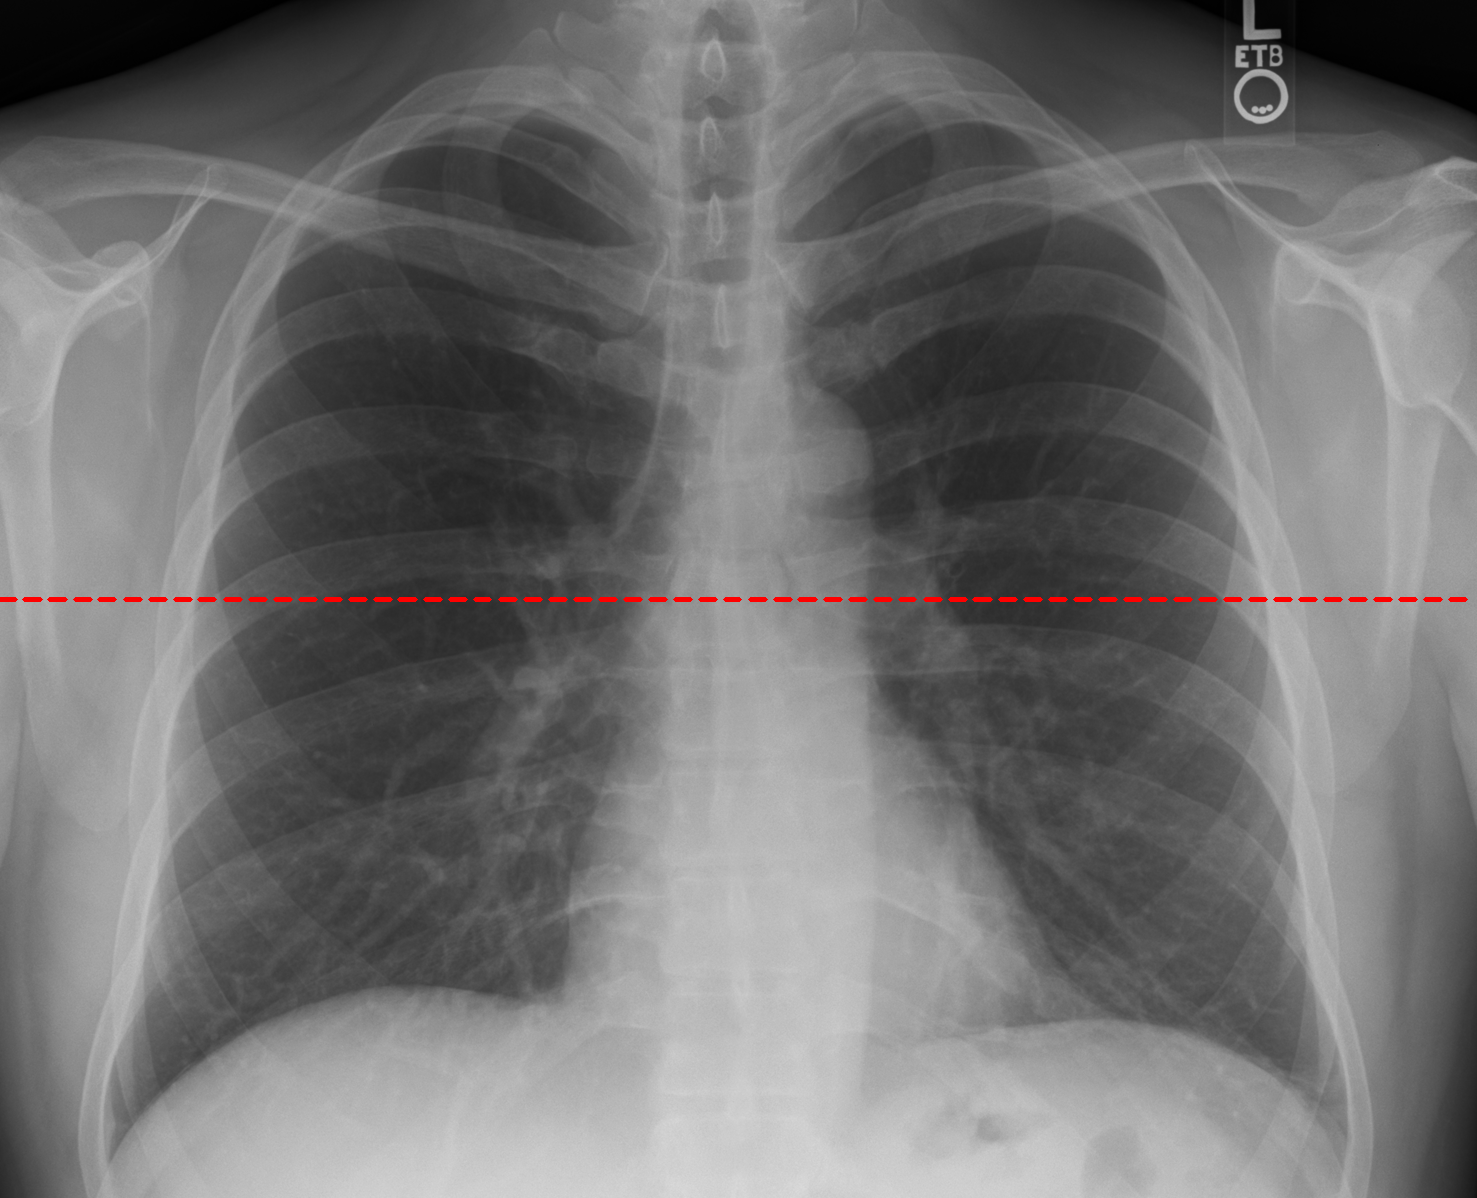

In [160]:
# --- Convertir imagen a base64 para incrustarla en HTML ---
open my $fh, '<:raw', $image_out or die "No se pudo abrir la imagen: $!";
my $raw_data = do { local $/; <$fh> };
close $fh;
my $b64 = encode_base64($raw_data, '');

# --- Trazas para el subplot ---

# Imagen como HTML (Plotly no admite imágenes directamente como matriz en Perl)
my $trace_img = {
    xaxis => 'x1',
    yaxis => 'y1',
    type  => 'image',
    source => "data:image/png;base64,$b64",
    x => 0,
    y => 0,
    sizex => 1,
    sizey => 1,
    xref => 'x1',
    yref => 'y1'
};

# Perfil de intensidad
my $trace_profile = Chart::Plotly::Trace::Scatter->new(
    x => \@x,
    y => \@y,
    mode => 'lines',
    name => "Perfil de Intensidad - Fila $fila",
    xaxis => 'x2',
    yaxis => 'y2',
    line => { color => '#636EFA', width => 2 }
);

# --- Layout con subplots ---
my $plot = Chart::Plotly::Plot->new(
    traces => [$trace_img, $trace_profile],
    layout => {
        grid => { rows => 1, columns => 2, pattern => 'independent' },
        xaxis  => { domain => [0.0, 0.45], anchor => 'y1' },
        yaxis  => { domain => [0.0, 1.0], anchor => 'x1', scaleanchor => 'x1' },
        xaxis2 => { domain => [0.55, 1.0], anchor => 'y2' },
        yaxis2 => { domain => [0.0, 1.0], anchor => 'x2' },
        title => 'Imagen Radiográfica y Perfil de Intensidad'
    }
);